# Binary Classification. UCI Sentiment Labelled Sentences II

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn

import re
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

print(f"Tensor Flow Version: {tf.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available." if gpu else "NOT AVAIALBLE!!!")
print(tf.config.list_physical_devices())

# II Data Preparation

### Read the Data in.

In [ ]:
colnames = ['review','is_positive']
raw = pd.read_csv('../data/uci_sentiment_lablelled_sentences/imdb_labelled.txt', sep=" \t", lineterminator="\n", names=colnames, engine='python', header=None)
raw

#engine='python' : The default 'c'- engine considers my sep value regex and will not parse it. 

### Exploratory Data Analysis [B1-2] 

In [ ]:
# Unusual Character Discovery

reviews = raw.review
character_list = []
for review in reviews:
    for character in review:
        if character not in character_list:
            character_list.append(character)

print(character_list)

In [ ]:
review_list = []
stop_words = stopwords.words('english')
lemma = nltk.WordNetLemmatizer()

for description in raw.review:
    description = re.sub("[^a-zA-Z0-9]"," ",description)
    description = description.lower()
    description = nltk.word_tokenize(description)
    description = [lemma.lemmatize(word) for word in description]
    review_list.append(description)

In [ ]:
#embedding length

review_length = []

for review in review_list:
    review_length.append(len(review))

plt.hist(review_length, bins = [0,20,40,60,80,100]) 

In [ ]:
# vocabuary size
vocabulary = []

for review in review_list:
    for word in review:
        if word not in vocabulary:
            vocabulary.append(word)
            
len(vocabulary)

### Tokenization

In [ ]:
keras_token = Tokenizer(oov_token = '[UNK]', lower=True)
keras_token.fit_on_texts(review_list)
word_count = keras_token.word_index

vocab_size = len(word_count)+1

print("Size of vocab:", len(word_count)+1)
list(word_count.items())[42:47]

In [ ]:
embedding_dim = len(review_list)
embedding_dim

### Padding Process [B3]

In [ ]:
sequence_train = keras_token.texts_to_sequences(review_list)
padded_train = pad_sequences(sequence_train,maxlen=100, padding='post', truncating='post')
padded_train.shape

In [ ]:
padded_train[0]

### [B5] Preparation for Analysis. (Train Validation Test Split)

In [ ]:
X = np.array(padded_train)
y = raw.is_positive.values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15, stratify=y)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

#view the training and testing sizes
print("Training Set Size: ", X_train.shape)
print("Testing Set Size: ", X_test.shape)

In [ ]:
# [B6] Export Datasets

X_training_df = pd.DataFrame(X_train)
X_testing_df = pd.DataFrame(X_test)
y_training_df = pd.DataFrame(y_train)
y_testing_df = pd.DataFrame(y_test)

X_training_df.to_csv('X_training.csv')
X_testing_df.to_csv('X_testing.csv')
y_training_df.to_csv('y_training.csv')
y_testing_df.to_csv('y_testing.csv')

# III Network Architecture

In [ ]:
activation = 'softmax'
loss = 'categorical_crossentropy'
optimizer = 'adam'
num_epochs = 20

early_stopping_monitor = EarlyStopping(patience=3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(1,activation=activation)
    
])

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [ ]:
model.summary()

In [78]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=num_epochs, 
                    validation_split=0.33, 
                    callbacks=[early_stopping_monitor],
                    verbose=True
                   )

Epoch 1/20
16/16 [==============================] - 1s 40ms/step - loss: 0.0000e+00 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.5081
Epoch 2/20
16/16 [==============================] - 1s 38ms/step - loss: 0.0000e+00 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.5081
Epoch 3/20
16/16 [==============================] - 1s 39ms/step - loss: 0.0000e+00 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.5081


# IV Model Evaluation

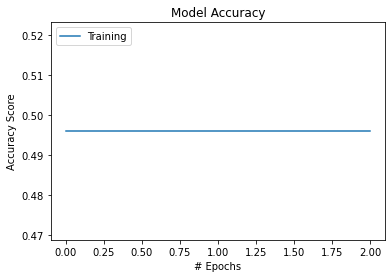

In [81]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('# Epochs')
plt.legend(['Training'], loc='upper left')
plt.show()

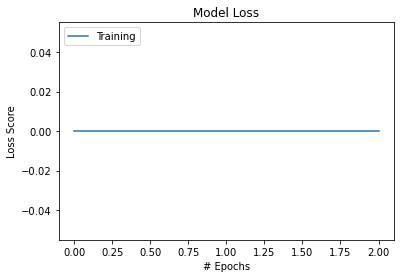

In [82]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss Score')
plt.xlabel('# Epochs')
plt.legend(['Training'], loc='upper left')
plt.show()